In [1]:
import seaborn as sns
from rich import print, inspect, traceback, pretty, progress
import pandas as pd


from chaotic_carbon_networks.preprocessing import concat_airs_data, concat_graced_data
from chaotic_carbon_networks.viz import plot_world
from chaotic_carbon_networks.hex import hexgrid, hex_to_latlon, filledgrid_from_hexgrid

sns.set_theme(context='paper', style="whitegrid", palette="Set2", font_scale=1.5, rc={'figure.figsize':(9,6)})
pretty.install()
traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f7ea4525450>>

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

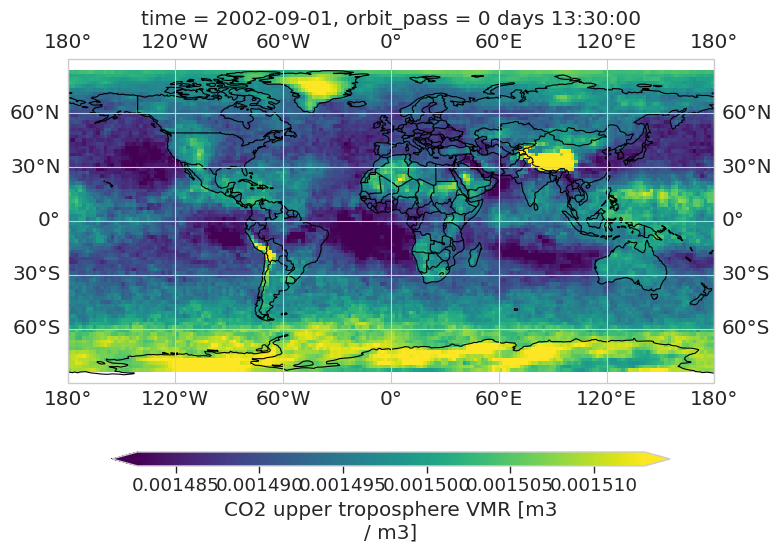

In [2]:
co2 = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")

# Rescale to 2x2 degree grid
co2 = co2.coarsen(lat=2, lon=2).sum()


plot_world(co2.isel(time=0))

## Usage

In [3]:
co2_hex = hexgrid(co2, hex_res=1)
co2_hex

<xarray.DataArray 'co2_vmr_uppertrop' (time: 255, vertex: 842)> Size: 859kB
array([[0.00150268, 0.00150384, 0.00150143, ..., 0.00150828, 0.00150701,
        0.00150862],
       [0.0015059 , 0.00150592, 0.00150581, ..., 0.00150632, 0.00150556,
        0.00150873],
       [0.00151095, 0.00151004, 0.00151178, ..., 0.00150292, 0.00150233,
        0.00150704],
       ...,
       [0.00165924, 0.00166229, 0.00165854, ..., 0.00167405, 0.00167207,
        0.00166942],
       [0.0016673 , 0.00167071, 0.00166748, ..., 0.00166799, 0.00166808,
        0.00166129],
       [0.00167396, 0.0016749 , 0.00167444, ..., 0.00166517, 0.00166633,
        0.00166153]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2002-09-01 2002-10-01 ... 2023-11-01
    orbit_pass  timedelta64[ns] 8B 13:30:00
  * vertex      (vertex) int64 7kB 580968749977305087 ... 585252447279120383
Attributes:
    units:                  m3 / m3
    ancillary_variables:    co2_vmr_uppertrop_nobs co2_vmr_uppertrop_sdev
    long_name:              CO2 upper troposphere VMR
    description:            Carbon Monoxide volume mixing ratio to dry air be...
    cell_methods:           area: mean
    coverage_content_type:  physicalMeasurement
    hex_res:                1

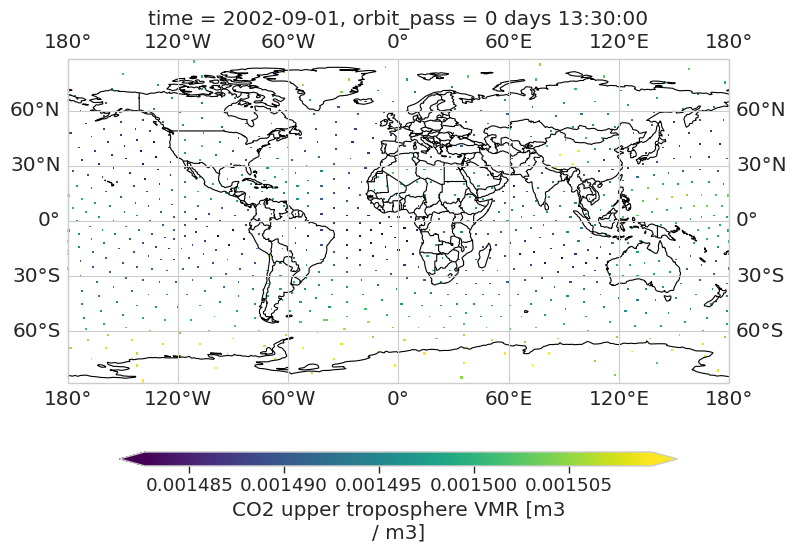

In [4]:
co2_hex_unstacked = hex_to_latlon(co2_hex, 0).unstack("vertex").isel(time=0)
# Remove hex_res attribute because it will result in a wrong plot
co2_hex_unstacked.attrs.pop("hex_res")
plot_world(co2_hex_unstacked)

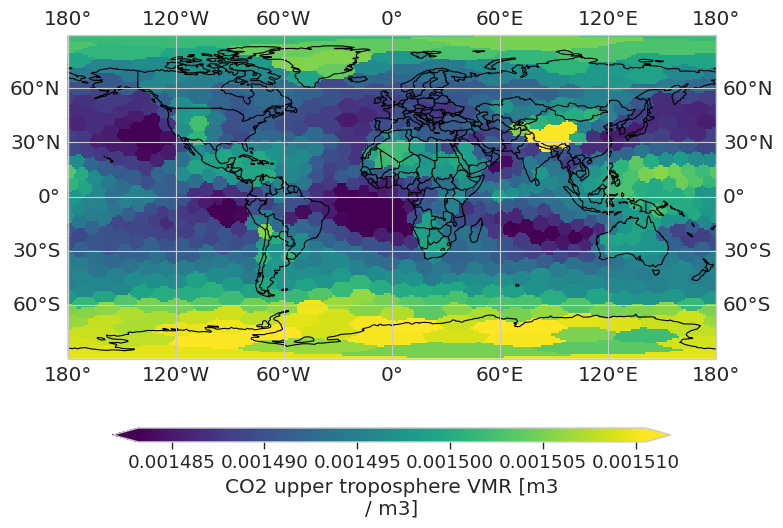

In [5]:
plot_world(filledgrid_from_hexgrid(co2_hex.isel(time=0), 1))

## Memory Usage

In [8]:
x = [5, 10, 20, 40]
xh = [4, 3, 2, 1]
res = []

with progress.Progress() as p:
    task = p.add_task("Calculating hexgrid sizes", total=len(x) * len(xh))
    for n in x:
        co2 = concat_graced_data(n, method="sum")
        for nh in xh:
            h = hexgrid(co2, hex_res=nh)
            res.append({
                "n": n,
                "nh": nh,
                "orig_size": co2.sizes["lat"] * co2.sizes["lon"],
                "hex_size": h.sizes["vertex"],
                "ratio": co2.sizes["lat"] * co2.sizes["lon"] / h.sizes["vertex"],
            })
            p.update(task, advance=1)

df = pd.DataFrame(res)
df

Output()

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_5x_sumed.nc

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_10x_sumed.nc

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_20x_sumed.nc

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_40x_sumed.nc

,n,nh,orig_size,hex_size,ratio
0,5,4,259200,195398,1.326523
1,5,3,259200,41162,6.297070
2,5,2,259200,5882,44.066644
3,5,1,259200,842,307.838480
4,10,4,64800,57126,1.134335
5,10,3,64800,38713,1.673856
6,10,2,64800,5882,11.016661
7,10,1,64800,842,76.959620
8,20,4,16200,15224,1.064109
9,20,3,16200,13688,1.183518


<Axes: xlabel='n', ylabel='ratio'>

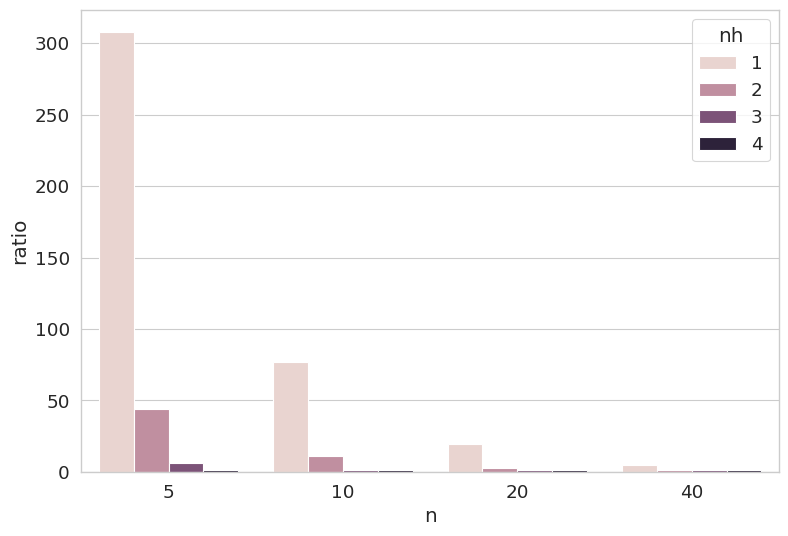

In [11]:
sns.barplot(df, x="n", y="ratio", hue="nh")

<Axes: xlabel='nh', ylabel='ratio'>

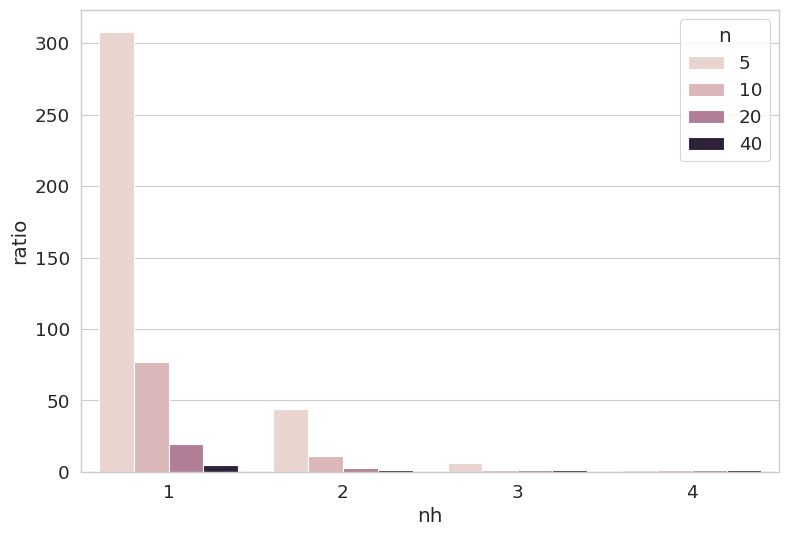

In [12]:
sns.barplot(df, x="nh", y="ratio", hue="n")